In [156]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import functools 
import operator

from sklearn import utils

import datetime
import csv
#import nltk
from sklearn.preprocessing import MultiLabelBinarizer


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split

In [157]:
# path for the csv files
DATA_PATH = os.path.join(os.getcwd(), 'data')

# loading data to pandas dataframe
def load_data(file_name): 
    file_path = os.path.join(DATA_PATH, file_name) 
    return pd.read_csv(file_path, parse_dates = ['purchase_date', 'release_date'])

def extract_dateinfo(df, col_name, datetype='year'):
    '''
    extract date type into specific year, month, date
    '''
    date_type = {'year': df[col_name].dt.year, 'month': df[col_name].dt.month, 'day': df[col_name].dt.day}[datetype]
    
    df.loc[:, col_name+'_'+ datetype] = date_type
    return df

#Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    for col in features:
        # calculating interquartile range
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR  
        
        # get the indices of outliers for feature col
        outliers_in_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the indices to oulier_indices
        outlier_indices.extend(outliers_in_col)
    
    outlier_indices = Counter(outlier_indices)
    result = list(k for k, v in outlier_indices.items() if v > n)
    
    return result

def process_string(string):
    '''
    split strings in categories/tags/genres 
    make all the words in lowercase
    remove all '-'
    '''
    string = string.lower()
    punctuation = "-"
    
    string = ''.join('' if c.isalpha()==False else c for c in string)
    
    return string

def get_cate_type_data(df, column_name):
    cate_list = list(df[column_name].apply(lambda x: set(x)))
    cate_list = set(functools.reduce(operator.iconcat, cate_list, []))
    return cate_list
    
def count_cate_game(df):
    df_copy = df.copy()
    df_copy = df_copy.transpose()
    return df_copy.astype(bool).sum(axis=1)

def plot_heat_map(corr, figsize=(30, 9)):
    plt.figure(figsize=figsize)
    g = sns.heatmap(corr, annot=True, cmap = "coolwarm")


In [158]:
train_set = load_data('train.csv')
test_set = load_data('test.csv')

In [159]:
train_set[train_set['playtime_forever'] == 0]

,id,playtime_forever,is_free,price,genres,categories,tags,purchase_date,release_date,total_positive_reviews,total_negative_reviews
0,0,0.0,False,3700.0,"Adventure,Casual,Indie","Single-player,Steam Trading Cards,Steam Cloud","Indie,Adventure,Story Rich,Casual,Atmospheric,...",2018-07-02,2013-12-10,372.0,96.0
2,2,0.0,False,5000.0,"Adventure,Casual,Indie","Single-player,Full controller support,Steam Tr...","Point & Click,Adventure,Story Rich,Comedy,Indi...",2018-07-02,2014-01-28,3018.0,663.0
10,10,0.0,False,6800.0,"Action,Adventure","Single-player,Steam Achievements,Partial Contr...","Action,Adventure,Hack and Slash,Third Person,S...",2018-01-30,2010-09-23,5893.0,700.0
11,11,0.0,False,2500.0,"Adventure,Indie,RPG,Strategy","Single-player,Steam Cloud","RPG,Post-apocalyptic,Classic,Turn-Based,Advent...",2017-06-23,2013-11-13,148.0,35.0
12,12,0.0,True,0.0,Action,"Single-player,Multi-player,Online Multi-Player...","Action,VR,Multiplayer",2019-07-20,2018-12-11,110.0,260.0
17,17,0.0,False,11200.0,"Indie,Simulation","Single-player,Steam Trading Cards,Steam Worksh...","Space,Simulation,Sandbox,Physics,Science,Space...",2019-05-30,2015-04-27,43103.0,4042.0
18,18,0.0,False,11200.0,"Simulation,Strategy","Single-player,Multi-player,Cross-Platform Mult...","Space,Strategy,Grand Strategy,Sci-fi,4X,Real-T...",2018-02-18,2016-05-09,30934.0,7777.0
19,19,0.0,False,3600.0,"Indie,Simulation,Strategy","Single-player,Multi-player,Steam Achievements,...","Strategy,Indie,Simulation,Space,Sci-fi,Moddabl...",2018-12-21,2015-04-16,74.0,115.0
22,22,0.0,False,8800.0,"Action,Adventure,Indie","Single-player,Steam Achievements,Full controll...","Atmospheric,Psychological,Story Rich,Female Pr...",2018-05-16,2017-08-07,20437.0,1847.0
24,24,0.0,False,12900.0,Strategy,"Single-player,Multi-player,Online Multi-Player...","Strategy,Space,Sci-fi,4X,Multiplayer,Turn-Base...",2019-04-02,2017-05-18,6812.0,1458.0


In [160]:
# Drop outliers from training data
outliers_to_drop = detect_outliers(train_set, 1 ,['price', 'total_positive_reviews', 'total_negative_reviews'])
train_set.loc[outliers_to_drop]
train_set = train_set.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

# merge training data and testing data 
game_info =  pd.concat(objs=[train_set, test_set], axis=0, sort=False).reset_index(drop=True)

#fill missing purchase date with the most frequent value in purchase_date column
game_info['purchase_date'].fillna(game_info['purchase_date'].mode()[0], inplace=True)


#fille missing number of positive_reviews and negative_reviews with zeros
game_info['total_positive_reviews'].fillna(0.0, inplace=True)
game_info['total_negative_reviews'].fillna(0.0, inplace=True)

#print(game_info.isnull().any().any())
#game_info['total_reviews_count'] = game_info['total_positive_reviews'] + game_info['total_negative_reviews']

#transfer boolean values to 1(true) and 0(false)
game_info['is_free'] = game_info['is_free'].map({False: 0.0, True: 1.0})

# extract year value
## year info
game_info = extract_dateinfo(game_info, 'purchase_date')
game_info = extract_dateinfo(game_info, 'release_date')

## month info
game_info = extract_dateinfo(game_info, 'purchase_date', datetype='month')
game_info = extract_dateinfo(game_info, 'release_date', datetype='month')

game_info['time_interval'] = game_info['purchase_date_year'] - game_info['release_date_year']
game_info.drop(columns=['purchase_date', 'release_date'], inplace=True)

game_info.drop(columns=['id'], inplace=True)

# split strings in the categorical columns
game_info['genres'] = game_info['genres'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['categories'] = game_info['categories'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['tags'] = game_info['tags'].str.split(',').apply(lambda x: list(map(process_string, x)))

temp_cate_ds = game_info[['genres', 'categories', 'tags']]

def __unique_tags__(row):
    col1 = row.iloc[0]
    col2 = row.iloc[1]
    col3 = row.iloc[2]
    one_two = set(col1) | set(col2)
    return list(one_two | set(col3))

game_info.loc[:, 'all_cate'] = temp_cate_ds.apply(__unique_tags__, axis=1)
game_info.loc[:, 'cate_count'] = game_info['all_cate'].apply(lambda x: len(x))

In [161]:
train_len = train_set.shape[0]
test_len = test_set.shape[0]

(train_len, test_len)

(324, 90)

In [162]:
game_info.head()

,playtime_forever,is_free,price,genres,categories,tags,total_positive_reviews,total_negative_reviews,purchase_date_year,release_date_year,purchase_date_month,release_date_month,time_interval,all_cate,cate_count
0,0.000000,0.0,3700.0,"[adventure, casual, indie]","[singleplayer, steamtradingcards, steamcloud]","[indie, adventure, storyrich, casual, atmosphe...",372.0,96.0,2018,2013,7,12,5,"[steamcloud, steamtradingcards, drama, indie, ...",15
1,0.016667,1.0,0.0,[rpg],"[singleplayer, partialcontrollersupport]","[mod, utilities, rpg, gamedevelopment, singlep...",23.0,0.0,2016,2015,11,8,1,"[utilities, freetoplay, singleplayer, partialc...",7
2,0.000000,0.0,5000.0,"[adventure, casual, indie]","[singleplayer, fullcontrollersupport, steamtra...","[pointclick, adventure, storyrich, comedy, ind...",3018.0,663.0,2018,2014,7,1,4,"[steamcloud, steamtradingcards, d, indie, clas...",23
3,1.533333,0.0,9900.0,"[action, rpg]","[singleplayer, multiplayer, steamachievements,...","[medieval, rpg, openworld, strategy, sandbox, ...",63078.0,1746.0,2016,2010,11,3,6,"[horses, steamtradingcards, multiplayer, rpg, ...",23
4,22.333333,0.0,4800.0,"[action, indie, strategy]","[singleplayer, coop, steamachievements, fullco...","[towerdefense, coop, action, strategy, onlinec...",8841.0,523.0,2018,2012,3,7,6,"[steamcloud, towerdefense, steamtradingcards, ...",25


In [163]:
#game_info['played'] = pd.Series(np.ones(train_len))

In [164]:
played = game_info['playtime_forever'] == 0

played = played.map({False: 0.0, True: 1.0})
game_info['played'] = played

In [165]:
num_info = game_info.columns.drop(['genres', 'categories', 'tags', 'playtime_forever'])
num_info

Index(['is_free', 'price', 'total_positive_reviews', 'total_negative_reviews',
       'purchase_date_year', 'release_date_year', 'purchase_date_month',
       'release_date_month', 'time_interval', 'all_cate', 'cate_count',
       'played'],
      dtype='object')

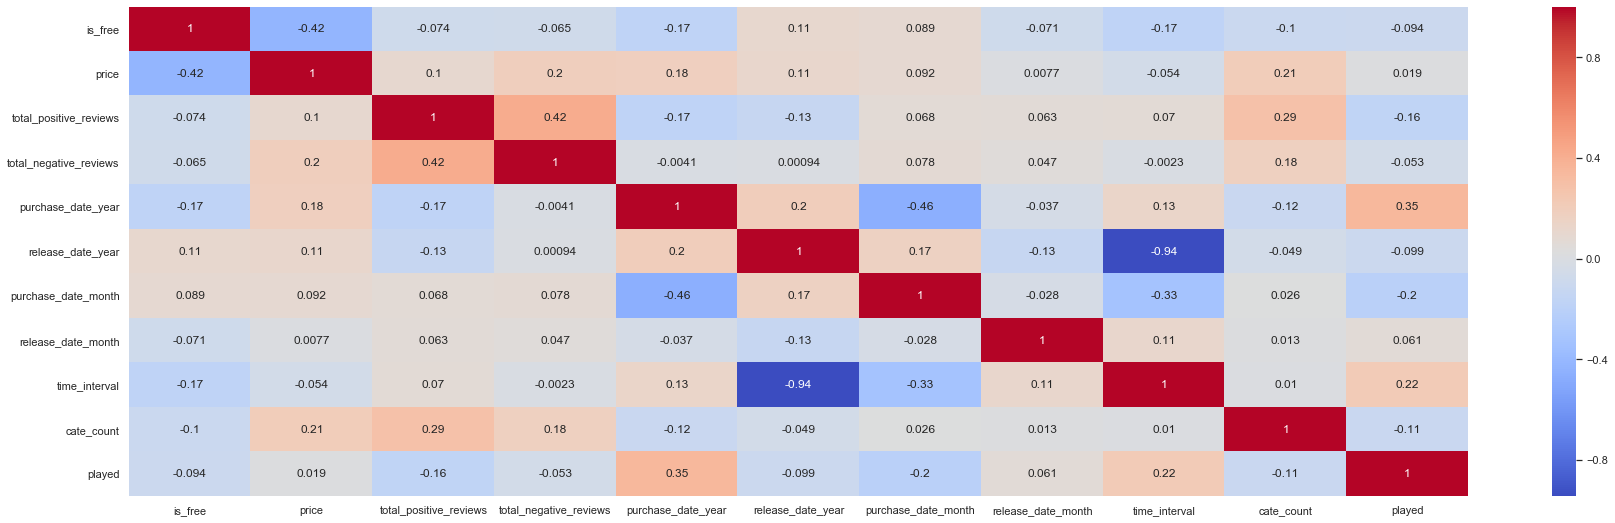

In [166]:
plot_heat_map(game_info.loc[:, num_info].corr())

In [167]:
pd.options.display.max_rows = 4000

cate_dataset = pd.get_dummies(game_info['all_cate'].apply(pd.Series).stack()).sum(level=0)
playtime = game_info['playtime_forever']
cate_time = pd.concat([playtime, cate_dataset], axis=1)

test_cate_set = get_cate_type_data(game_info[train_len:], 'all_cate')
train_cate_set = get_cate_type_data(game_info[:train_len], 'all_cate')
cate_list = list(test_cate_set.intersection(train_cate_set))
cate_time = cate_time[['playtime_forever'] + list(cate_list)]


In [168]:
time_corr = cate_time.corr().loc['playtime_forever', :]
high_corr_tags = list(time_corr[np.abs(time_corr.values) > 0.2 ].drop('playtime_forever').index)

num_game = count_cate_game(cate_time).drop('playtime_forever')
mid_range_tags = list(num_game[(num_game.values < 200) & (num_game.values > 50)].sort_values().index)

In [169]:
mid_range_tags

['classic',
 'gore',
 'steamworkshop',
 'onlinemultiplayer',
 'fps',
 'pointclick',
 'femaleprotagonist',
 'steamleaderboards',
 'comedy',
 'sandbox',
 'survival',
 'partialcontrollersupport',
 'exploration',
 'horror',
 'shooter',
 'onlinecoop',
 'difficult',
 'firstperson',
 'funny',
 'thirdperson',
 'casual',
 'masterpiece',
 'simulation',
 'puzzle',
 'd',
 'fantasy',
 'scifi',
 'coop',
 'strategy',
 'openworld',
 'rpg',
 'multiplayer',
 'fullcontrollersupport',
 'storyrich']

In [170]:
chosen_tags1 = list(set(high_corr_tags).union(set(mid_range_tags)))
#chosen_tags1 = mid_range_tags
cate_time = cate_time.loc[:, ['playtime_forever']+ chosen_tags1]
cate_time.head()


,playtime_forever,turnbased,turnbasedtactics,partybasedrpg,d,partialcontrollersupport,multiplayer,classic,horror,crpg,...,puzzle,fps,coop,femaleprotagonist,funny,scifi,storyrich,survival,turnbasedcombat,steamleaderboards
0,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.016667,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0,0,0,1,0,0,1,0,0,...,1,0,0,1,1,1,1,0,0,0
3,1.533333,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22.333333,0,0,0,0,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,1


In [171]:
#temp = cate_time.sort_values(by='playtime_forever', ascending=False).drop(columns=['playtime_forever'])[:40]
temp = cate_time.sort_values(by='playtime_forever').drop(columns=['playtime_forever'])[0:159]
#temp = cate_time.sort_values(by='playtime_forever')[159:199]
cols = temp.columns
bt = temp.apply(lambda x: x > 0)
top20 = bt.apply(lambda x: list(cols[x.values]), axis=1)

In [172]:
top20

0          [casual, firstperson, exploration, storyrich]
162    [multiplayer, fantasy, strategy, onlinecoop, r...
164    [horror, openworld, firstperson, exploration, ...
165    [partybasedrpg, multiplayer, classic, crpg, fa...
166    [partialcontrollersupport, classic, openworld,...
168    [d, masterpiece, pointclick, gore, strategy, d...
170    [horror, openworld, firstperson, exploration, ...
172    [classic, horror, shooter, firstperson, rpg, f...
174    [openworld, gore, firstperson, exploration, fu...
177    [partialcontrollersupport, multiplayer, master...
182    [turnbased, multiplayer, onlinemultiplayer, fa...
183    [horror, masterpiece, openworld, firstperson, ...
185    [turnbased, partialcontrollersupport, crpg, op...
186    [d, openworld, pointclick, strategy, simulatio...
187                                                   []
188    [horror, pointclick, gore, fullcontrollersuppo...
193    [partialcontrollersupport, multiplayer, master...
194          [pointclick, fullc

In [173]:
from collections import Counter 
import itertools
flat_top20 = itertools.chain.from_iterable(top20.values)
flat_top20 = list(flat_top20)

Counter(flat_top20).most_common()



[('storyrich', 69),
 ('fullcontrollersupport', 66),
 ('multiplayer', 60),
 ('scifi', 56),
 ('strategy', 49),
 ('puzzle', 48),
 ('rpg', 45),
 ('fantasy', 44),
 ('openworld', 44),
 ('coop', 41),
 ('masterpiece', 40),
 ('horror', 37),
 ('d', 36),
 ('firstperson', 33),
 ('thirdperson', 33),
 ('pointclick', 32),
 ('comedy', 29),
 ('femaleprotagonist', 28),
 ('gore', 28),
 ('shooter', 27),
 ('steamleaderboards', 27),
 ('simulation', 26),
 ('fps', 26),
 ('funny', 25),
 ('classic', 24),
 ('partialcontrollersupport', 23),
 ('onlinecoop', 22),
 ('exploration', 21),
 ('casual', 20),
 ('difficult', 20),
 ('onlinemultiplayer', 18),
 ('sandbox', 18),
 ('survival', 17),
 ('steamworkshop', 17),
 ('turnbased', 16),
 ('crpg', 6),
 ('turnbasedtactics', 4),
 ('turnbasedcombat', 3),
 ('partybasedrpg', 1)]

In [174]:
count_cate_game(cate_time).sort_values(ascending=False)

playtime_forever            261
storyrich                   179
fullcontrollersupport       175
multiplayer                 168
rpg                         148
openworld                   135
strategy                    129
coop                        122
scifi                       112
fantasy                     109
d                           104
puzzle                      101
simulation                   94
masterpiece                  91
casual                       90
thirdperson                  80
funny                        80
firstperson                  80
difficult                    73
onlinecoop                   73
horror                       72
shooter                      72
exploration                  67
partialcontrollersupport     67
survival                     66
sandbox                      66
comedy                       64
steamleaderboards            61
femaleprotagonist            60
pointclick                   60
onlinemultiplayer            55
fps     

In [175]:
cate_time.corr().loc['playtime_forever', :].sort_values()

puzzle                     -0.094106
horror                     -0.085406
scifi                      -0.084214
pointclick                 -0.068162
firstperson                -0.067525
masterpiece                -0.060885
fps                        -0.056965
classic                    -0.046849
comedy                     -0.045336
partialcontrollersupport   -0.034787
shooter                    -0.029358
funny                      -0.014673
storyrich                  -0.002409
gore                        0.005154
thirdperson                 0.013088
simulation                  0.016688
survival                    0.028432
casual                      0.031659
d                           0.037628
steamleaderboards           0.039991
sandbox                     0.049592
femaleprotagonist           0.054439
exploration                 0.060987
difficult                   0.066635
openworld                   0.102916
multiplayer                 0.105031
fullcontrollersupport       0.106971
s

In [176]:
cate_time.corr().loc['steamworkshop', :].sort_values(ascending=False)

steamworkshop               1.000000
sandbox                     0.354439
strategy                    0.274468
playtime_forever            0.225683
coop                        0.184076
multiplayer                 0.183784
onlinemultiplayer           0.182274
openworld                   0.152801
turnbased                   0.146699
simulation                  0.144600
onlinecoop                  0.136355
survival                    0.101711
crpg                        0.098321
rpg                         0.094116
fantasy                     0.089186
steamleaderboards           0.078226
turnbasedtactics            0.059065
scifi                       0.049994
femaleprotagonist           0.041018
turnbasedcombat             0.039252
partybasedrpg               0.031126
exploration                 0.021236
d                           0.019421
casual                      0.018004
difficult                   0.005638
comedy                     -0.009890
funny                      -0.011319
f

In [177]:
def create_new_group(feature, threshold=0.3):
    '''
    group similar categories
    '''
    corr = cate_time.corr().loc[feature, :].sort_values(ascending=False)
    group = list(corr[corr.values > threshold].index)
    
    if 'playtime_forever' in group:
        group.remove('playtime_forever')
    
    return group

In [178]:
rpg = create_new_group('rpg', threshold=0.2)
rpg.remove('turnbased')
turnbase = create_new_group('turnbasedcombat', threshold=0.4)
multiplayer = create_new_group('multiplayer', 0.4)
strategy = ['simulation', 'strategy', 'steamworkshop']
rpg_controller = rpg + ['fullcontrollersupport']
multiplayer_strategy = list(set(multiplayer + strategy))
puzzle = ['puzzle', 'pointclick']

In [179]:
rpg_controller
#multiplayer_strategy

['rpg',
 'fantasy',
 'crpg',
 'openworld',
 'partybasedrpg',
 'coop',
 'fullcontrollersupport']

In [180]:
def create_new_cate(all_cate_list, new_feature, intersection=1):
    if len(set(all_cate_list).intersection(set(new_feature))) >= intersection:
        return 1.0
    else:
        return 0.0

In [181]:
# game_info['is_addictive'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, addictive))
# game_info['is_multiplayer'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer))
#game_info['is_remote'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, remote))
game_info['rpg_controller'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, rpg_controller, intersection=3))
game_info['multiplayer_strategy'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer_strategy, intersection=len(multiplayer_strategy)))
game_info['is_turnbase'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, turnbase))
#game_info['is_puzzle'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, puzzle, 2))
#game_info['is_multiplayer'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer))
#game_info['is_strategy'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, strategy))
#game_info['strategy_controller'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, strategy_controller))

game_info.head()

,playtime_forever,is_free,price,genres,categories,tags,total_positive_reviews,total_negative_reviews,purchase_date_year,release_date_year,purchase_date_month,release_date_month,time_interval,all_cate,cate_count,played,rpg_controller,multiplayer_strategy,is_turnbase
0,0.000000,0.0,3700.0,"[adventure, casual, indie]","[singleplayer, steamtradingcards, steamcloud]","[indie, adventure, storyrich, casual, atmosphe...",372.0,96.0,2018,2013,7,12,5,"[steamcloud, steamtradingcards, drama, indie, ...",15,1.0,0.0,0.0,0.0
1,0.016667,1.0,0.0,[rpg],"[singleplayer, partialcontrollersupport]","[mod, utilities, rpg, gamedevelopment, singlep...",23.0,0.0,2016,2015,11,8,1,"[utilities, freetoplay, singleplayer, partialc...",7,0.0,0.0,0.0,0.0
2,0.000000,0.0,5000.0,"[adventure, casual, indie]","[singleplayer, fullcontrollersupport, steamtra...","[pointclick, adventure, storyrich, comedy, ind...",3018.0,663.0,2018,2014,7,1,4,"[steamcloud, steamtradingcards, d, indie, clas...",23,1.0,0.0,0.0,0.0
3,1.533333,0.0,9900.0,"[action, rpg]","[singleplayer, multiplayer, steamachievements,...","[medieval, rpg, openworld, strategy, sandbox, ...",63078.0,1746.0,2016,2010,11,3,6,"[horses, steamtradingcards, multiplayer, rpg, ...",23,0.0,1.0,0.0,0.0
4,22.333333,0.0,4800.0,"[action, indie, strategy]","[singleplayer, coop, steamachievements, fullco...","[towerdefense, coop, action, strategy, onlinec...",8841.0,523.0,2018,2012,3,7,6,"[steamcloud, towerdefense, steamtradingcards, ...",25,0.0,1.0,0.0,0.0


In [182]:
temp_df = game_info.loc[:, ['playtime_forever', 'multiplayer_strategy', 'rpg_controller', 'is_turnbase', 'is_puzzle']]
temp_df.corr()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,playtime_forever,multiplayer_strategy,rpg_controller,is_turnbase,is_puzzle
playtime_forever,1.000000,0.276465,0.242234,0.204625,NaN
multiplayer_strategy,0.276465,1.000000,0.109056,-0.022150,NaN
rpg_controller,0.242234,0.109056,1.000000,0.221007,NaN
is_turnbase,0.204625,-0.022150,0.221007,1.000000,NaN
is_puzzle,NaN,NaN,NaN,NaN,NaN


In [183]:
#cate_features = ['puzzle']

In [196]:
droplist = ['is_free', 'genres', 'categories', 'tags', 'total_negative_reviews', 'purchase_date_year',
           'release_date_year', 'release_date_month', 'played', 'all_cate', 'price']

game_data = pd.concat([game_info.drop(columns=droplist), cate_time.loc[:, cate_features]], axis=1)
#game_data = pd.concat([game_info.drop(columns=droplist), cate_time], axis=1)
game_data.head()

,playtime_forever,total_positive_reviews,purchase_date_month,time_interval,cate_count,rpg_controller,multiplayer_strategy,is_turnbase,puzzle
0,0.000000,372.0,7,5,15,0.0,0.0,0.0,0
1,0.016667,23.0,11,1,7,0.0,0.0,0.0,0
2,0.000000,3018.0,7,4,23,0.0,0.0,0.0,1
3,1.533333,63078.0,11,6,23,1.0,0.0,0.0,0
4,22.333333,8841.0,3,6,25,1.0,0.0,0.0,0


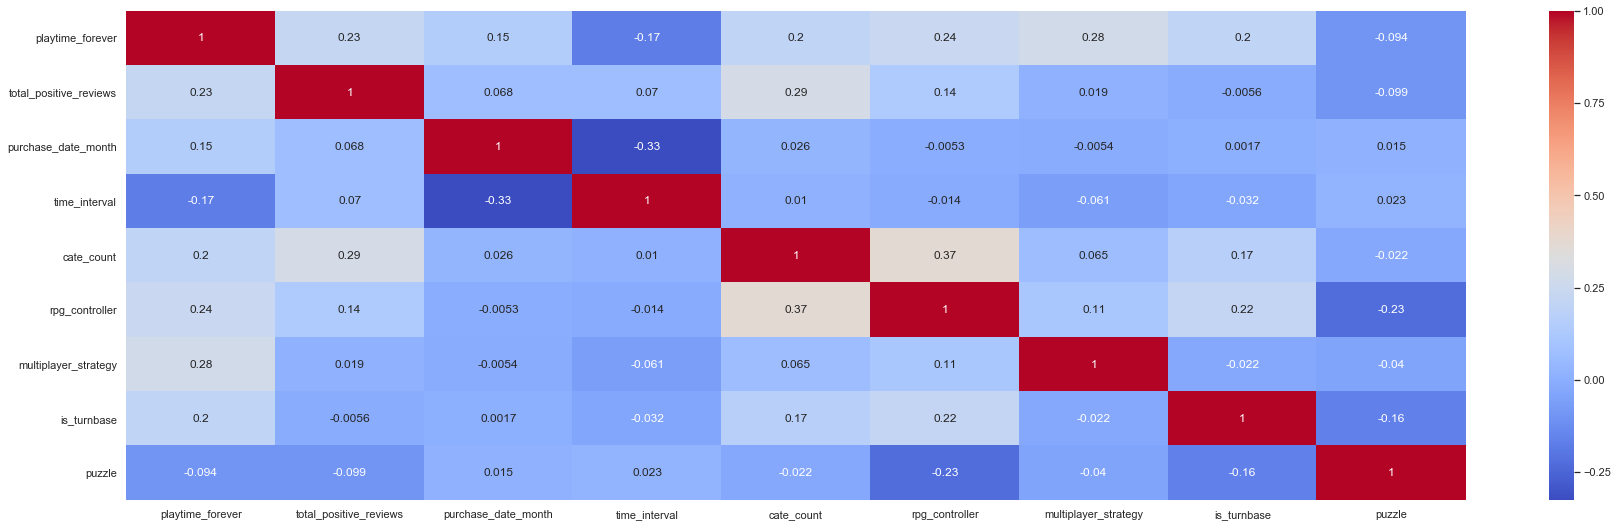

In [197]:
plot_heat_map(game_data.corr())

In [198]:
from sklearn import datasets, linear_model

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
import lightgbm as lgb

In [199]:
train_data = game_data[:train_len]
test_data = game_data[train_len:]

train_label = train_data['playtime_forever']
train_data = train_data.drop(columns=['playtime_forever'])
test_data.drop(columns=['playtime_forever'],inplace=True)


print('train_data shape: ', train_data.shape)
print('train_label shape: ', train_label.shape)
print('test_data shape : ', test_data.shape)

train_data.head()

train_data shape:  (324, 8)
train_label shape:  (324,)
test_data shape :  (90, 8)


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,total_positive_reviews,purchase_date_month,time_interval,cate_count,rpg_controller,multiplayer_strategy,is_turnbase,puzzle
0,372.0,7,5,15,0.0,0.0,0.0,0
1,23.0,11,1,7,0.0,0.0,0.0,0
2,3018.0,7,4,23,0.0,0.0,0.0,1
3,63078.0,11,6,23,1.0,0.0,0.0,0
4,8841.0,3,6,25,1.0,0.0,0.0,0


In [200]:
n_folds = 12

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data)
    rmse= np.sqrt(-cross_val_score(model, train_data, train_label, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [201]:
KRR = make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.0001, fit_intercept=True, normalize=True))
#model_ridge = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=5)

decisionTree = DecisionTreeRegressor(random_state=0, max_depth = 2)

In [202]:
lasso_score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(lasso_score.mean(), lasso_score.std()))

enet_score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(enet_score.mean(), enet_score.std()))

krr_score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(krr_score.mean(), krr_score.std()))

ridge_score = rmsle_cv(model_ridge)
print("ridge score: {:.4f} ({:.4f})\n" .format(ridge_score.mean(), ridge_score.std()))

randomtree_score = rmsle_cv(regr)
print("Random Tree score: {:.4f} ({:.4f})\n".format(randomtree_score.mean(), randomtree_score.std()))

decision_score = rmsle_cv(decisionTree)
print("decision score: {:.4f} ({:.4f})\n" .format(decision_score.mean(), decision_score.std()))

gboost_score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(gboost_score.mean(), gboost_score.std()))

#xgb_score = rmsle_cv(model_xgb)
#print("Xgboost score: {:.4f} ({:.4f})\n".format(xgb_score.mean(), xgb_score.std()))

#lgb_score = rmsle_cv(model_lgb)
#print("LGBM score: {:.4f} ({:.4f})\n" .format(lgb_score.mean(), lgb_score.std()))


Lasso score: 6.7863 (4.1067)

ElasticNet score: 6.7753 (4.0977)

Kernel Ridge score: 5.4376 (2.5828)

ridge score: 6.7912 (4.1098)

Random Tree score: 6.8956 (5.5882)

decision score: 7.8470 (7.7033)

Gradient Boosting score: 5.2109 (4.3534)



In [203]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [204]:
averaged_models = AveragingModels(models = (decisionTree, ENet, KRR))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))




 Averaged base models score: 6.0184 (4.4664)



In [208]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.25, random_state=42)



averaged_models.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
KRR.fit(X_train, y_train)
decisionTree.fit(X_train, y_train)

ave_pred = averaged_models.predict(X_val)
rid_pred = model_ridge.predict(X_val)
lgb_pred = model_lgb.predict(X_val)
krr_pred = KRR.predict(X_val)
dt_pred = decisionTree.predict(X_val)


print("LGB Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, lgb_pred)))
print("Average Model Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, ave_pred)))
print("Ridge Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, rid_pred)))
print("KRR Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, krr_pred)))
print("DT Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, dt_pred)))

LGB Root Mean squared error:  4.731604232707489
Average Model Root Mean squared error:  5.977053432974529
Ridge Root Mean squared error:  6.932815919116093
KRR Root Mean squared error:  5.493468937291045
DT Root Mean squared error:  7.742833270397422


In [209]:
#model2.fit(X_train, y_train)
rid_test_pred = model_ridge.predict(test_data)

ave_test_pred = averaged_models.predict(test_data)

lgb_test_pred = model_lgb.predict(test_data)

krr_test_pred = KRR.predict(test_data)

In [210]:
def import_result(y_test_pred, filename):
    result_df = pd.DataFrame(y_test_pred, columns =['playtime_forever']) 
    result_df.index.name = 'id'
    result_df.to_csv(filename)

In [211]:
import_result(krr_test_pred, 'result.csv')